In [79]:
import json
import os
from graphviz import Digraph

def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def count_metrics(node, paths=None, current_path=None):
    if paths is None:
        paths = set()
    if current_path is None:
        current_path = []
        
    current_path = current_path + [str(id(node))]
    
    children = node.get('children', [])
    paths.add(tuple(current_path))
    if not children:  # Leaf node
        # paths.add(tuple(current_path))
        mc_value = node.get('mc_value', 0)
        return 1, 1 if mc_value == 1.0 else 0, paths
        
    leaf_count = 0
    success_count = 0
    for child in children:
        child_leaf, child_success, _ = count_metrics(child, paths, current_path)
        leaf_count += child_leaf
        success_count += child_success
        
    return leaf_count, success_count, paths

def add_nodes_edges(dot, node, parent_id=None):
    node_id = str(id(node))
    text = node.get('text', '') + "'"  # Increased text length for better readability
    dot.node(node_id, label=text, shape='box', style='filled', fillcolor='lightblue', 
            fontname='helvetica', fontsize='10')
    
    if parent_id is not None:
        # Add mc_value as edge label in red
        mc_value = node.get('mc_value', 0)
        dot.edge(parent_id, node_id, label=f"{mc_value}", fontcolor="red", 
                fontname='helvetica', fontsize='20')
    
    for child in node.get('children', []):
        add_nodes_edges(dot, child, node_id)

def visualize_tree(json_data, name='mcts_tree', save_dir='mcts_trees'):
    os.makedirs(save_dir, exist_ok=True)
    dot = Digraph(comment='MCTS Tree', format='png')
    # Set default node attributes
    dot.attr('node', shape='box', style='filled', fillcolor='lightblue', 
            fontname='helvetica', fontsize='20')
    # Set default edge attributes
    dot.attr('edge', fontcolor='red', fontname='helvetica', fontsize='20')
    
    add_nodes_edges(dot, json_data)
    # Increase the spacing between nodes
    dot.attr(ranksep='1', nodesep='1')
    dot.render(os.path.join(save_dir, name), cleanup=True)
    
    # Count and print metrics
    leaf_count, success_count, paths = count_metrics(json_data)
    print(f"Number of leaf nodes: {leaf_count}")
    print(f"Number of successful leaf nodes (mc_value=1.0): {success_count}")
    print(f"Number of distinct paths: {len(paths)}")

# if __name__ == "__main__":
json_data = load_json('collected_solutions2.json')
visualize_tree(json_data)

Number of leaf nodes: 10
Number of successful leaf nodes (mc_value=1.0): 6
Number of distinct paths: 14


In [80]:
from tqdm import tqdm

leaf_counts = []
success_counts = []
path_counts = []

failed_trees_count = 0

for j in range(1, 9):
    with open(f'/data/jianyuan/openr/data/omegaPRM_v2/output_results_data/results_part_{j}.json/math-aps-v2.jsonl', 'r') as file:
        offset_idx = len(leaf_counts)
        lines = file.readlines()
        for i, line in enumerate(tqdm(lines, desc="Processing trees")):
            data = json.loads(line)
            # visualize_tree(data['reasoning_steps'], name=f'mcts_tree_{i+offset_idx}')
            leaf_count, success_count, paths = count_metrics(data['reasoning_steps'])

            if leaf_count == 1:
                failed_trees_count += 1
                continue
            
            leaf_counts.append(leaf_count)
            success_counts.append(success_count) 
            path_counts.append(len(paths))


print('number of terminating nodes', sum(leaf_counts))
print('number of unique paths', sum(path_counts))
print('number of failed trees', failed_trees_count)
success_rate = sum(1 for count in success_counts if count > 0) / (len(success_counts) + failed_trees_count)
print(f'Success rate: {success_rate:.2%}')

Processing trees:   0%|          | 0/801 [00:00<?, ?it/s]

Processing trees: 100%|██████████| 876/876 [00:00<00:00, 5612.91it/s]

number of terminating nodes 309026
number of unique paths 347115
number of failed trees 1033
Success rate: 84.38%


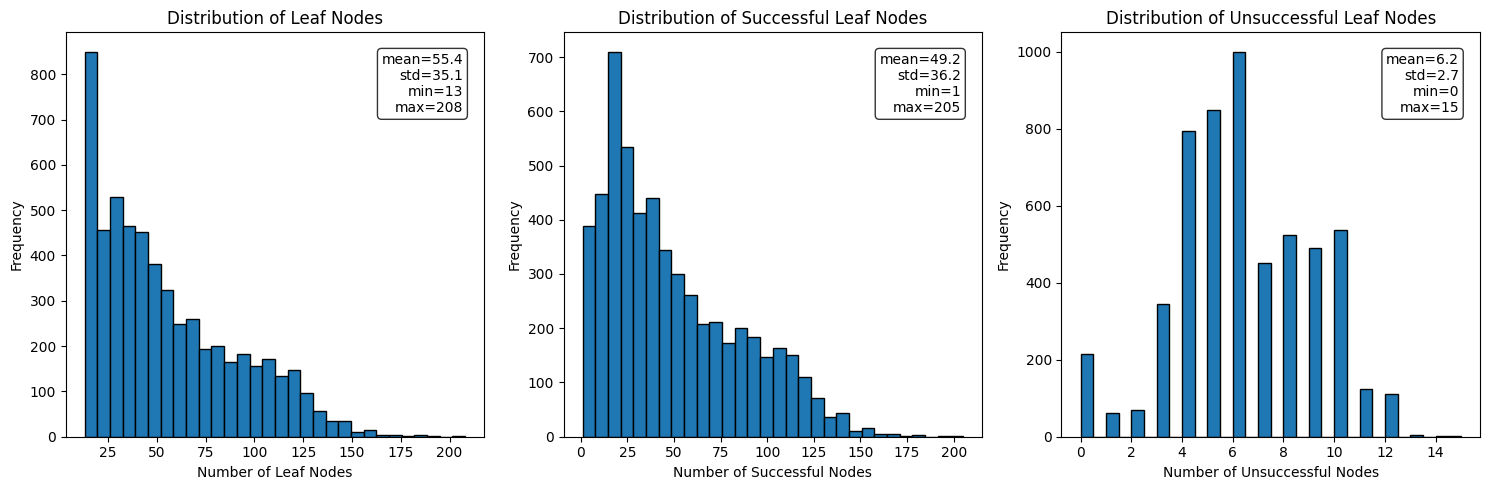

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram for leaf counts
ax1.hist(leaf_counts, bins=30, edgecolor='black')
ax1.set_title('Distribution of Leaf Nodes')
ax1.set_xlabel('Number of Leaf Nodes')
ax1.set_ylabel('Frequency')
stats1 = f'mean={np.mean(leaf_counts):.1f}\nstd={np.std(leaf_counts):.1f}\n'
stats1 += f'min={np.min(leaf_counts)}\nmax={np.max(leaf_counts)}'
ax1.text(0.95, 0.95, stats1, transform=ax1.transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot histogram for success counts
ax2.hist(success_counts, bins=30, edgecolor='black')
ax2.set_title('Distribution of Successful Leaf Nodes')
ax2.set_xlabel('Number of Successful Nodes')
ax2.set_ylabel('Frequency')
stats2 = f'mean={np.mean(success_counts):.1f}\nstd={np.std(success_counts):.1f}\n'
stats2 += f'min={np.min(success_counts)}\nmax={np.max(success_counts)}'
ax2.text(0.95, 0.95, stats2, transform=ax2.transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot histogram for unsuccessful leaf nodes
unsuccessful_counts = [l - s for l, s in zip(leaf_counts, success_counts)]
ax3.hist(unsuccessful_counts, bins=30, edgecolor='black')
ax3.set_title('Distribution of Unsuccessful Leaf Nodes')
ax3.set_xlabel('Number of Unsuccessful Nodes')
ax3.set_ylabel('Frequency')
stats3 = f'mean={np.mean(unsuccessful_counts):.1f}\nstd={np.std(unsuccessful_counts):.1f}\n'
stats3 += f'min={np.min(unsuccessful_counts)}\nmax={np.max(unsuccessful_counts)}'
ax3.text(0.95, 0.95, stats3, transform=ax3.transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


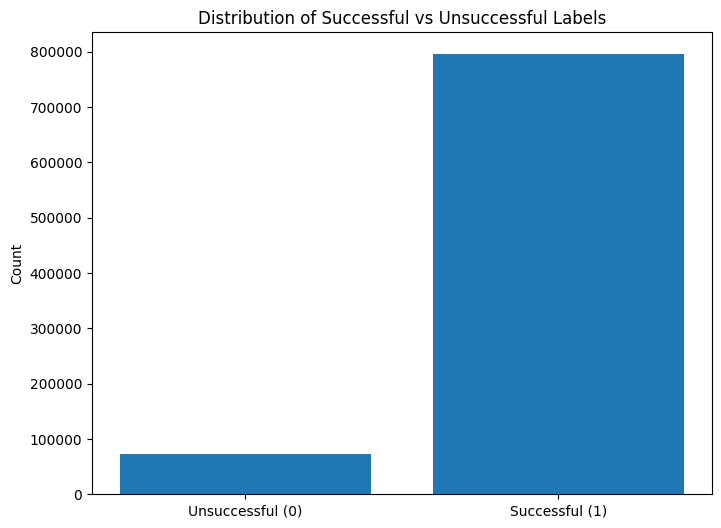

In [10]:
import json
import matplotlib.pyplot as plt

with open('/data/jianyuan/LLMreasoning/balance_training_dataset.jsonl', 'r') as f:
    data = [json.loads(line) for line in f]


zero_count = 0
one_count = 0
for d in data:
    for l in d['label']:
        if l == 0:
            zero_count += 1
        else:
            one_count += 1

plt.figure(figsize=(8, 6))
plt.bar(['Unsuccessful (0)', 'Successful (1)'], [zero_count, one_count])
plt.title('Distribution of Successful vs Unsuccessful Labels')
plt.ylabel('Count')
plt.show()

Using the latest cached version of the dataset since peiyi9979/Math-Shepherd couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/jianyuanzhong/.cache/huggingface/datasets/peiyi9979___math-shepherd/default/0.0.0/ae6b0c54fca9fa26096f7de175c747e4b262e01a (last modified on Tue Jan 14 15:23:52 2025).
100%|██████████| 444655/444655 [00:27<00:00, 16433.00it/s]


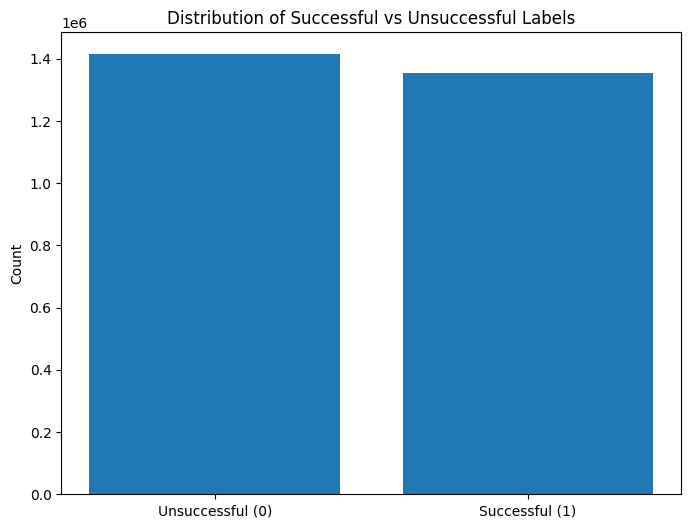

In [18]:
from datasets import load_dataset
from tqdm import tqdm

dataset = load_dataset('peiyi9979/Math-Shepherd')
step_tag2 = 'ки'

examples = []
for data in tqdm(dataset['train']):
    # the first sentence is the question
    question = ''

    # the rest in the input is the process
    process = data['input']

    # the label is the last sentence
    label_indices = [i for i, label in enumerate(data['input'].split()) if label == step_tag2]
    labels = [s for i, s in enumerate(data['label'].split()) if i in label_indices]

    examples.append({'question': question, 'process': process, 'label': labels})

zero_count = 0
last_one_zero = 0
one_count = 0
last_one_one = 0
for d in examples:
    for l in d['label']:
        if l == '-':
            zero_count += 1
        else:
            one_count += 1

plt.figure(figsize=(8, 6))
plt.bar(['Unsuccessful (0)', 'Successful (1)'], [zero_count, one_count])
plt.title('Distribution of Successful vs Unsuccessful Labels')
plt.ylabel('Count')
plt.show()

In [19]:
# dump the dataset
with open('/data/jianyuan/LLMreasoning/math_shepherd_dataset.jsonl', 'w') as f:
    for d in examples:
        json.dump(d, f)
        f.write('\n')

Separating positive and negative samples: 100%|██████████| 309332/309332 [05:25<00:00, 949.25it/s] 


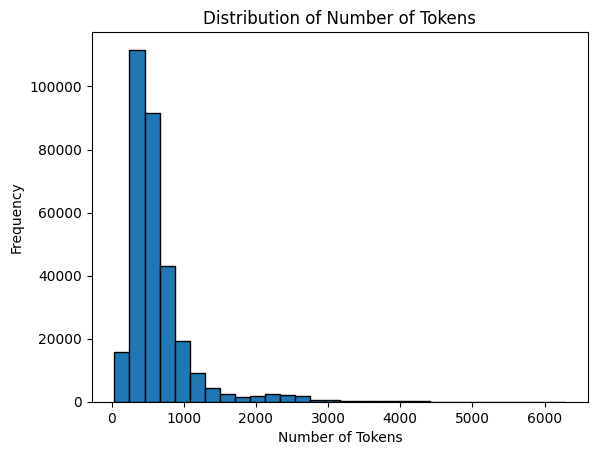

In [20]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    'meta-llama/Llama-3.1-8B-Instruct', 
    add_eos_token=False, 
)

file_path = "/data/jianyuan/LLMreasoning/merged_training_dataset.jsonl"

with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file]

num_tokens = []
for d in tqdm(data, desc="Separating positive and negative samples"):
    # tokenize the process
    input_str = f"{d['question']} {d['process']}"
    process = tokenizer.encode(input_str)
    num_tokens.append(len(process))

plt.hist(num_tokens, bins=30, edgecolor='black')
plt.title('Distribution of Number of Tokens')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

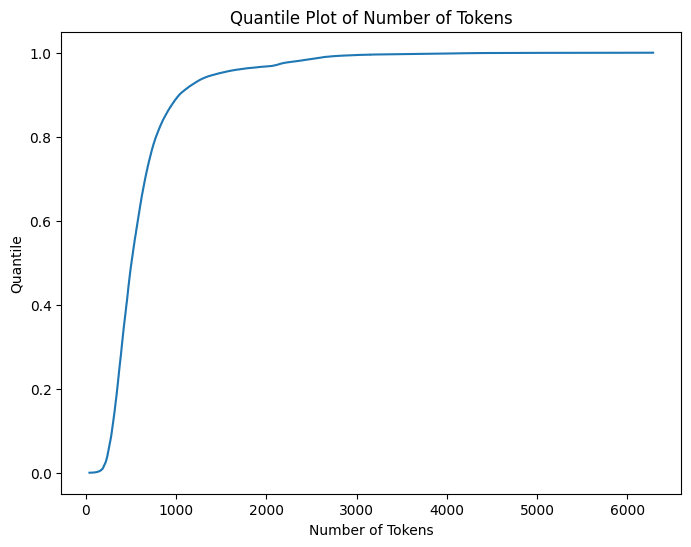

In [22]:
import numpy as np

# plot the quantile plot
plt.figure(figsize=(8, 6))
plt.plot(np.sort(num_tokens), np.linspace(0, 1, len(num_tokens)))
plt.title('Quantile Plot of Number of Tokens')
plt.xlabel('Number of Tokens')
plt.ylabel('Quantile')
plt.show()